In [3]:
using Revise; 
includet("TrajModules.jl")
using .atom_class
using .SystemSetup
using .utils
using .BeamClass
using .CoolTrap
using .IntegrateODE

In [2]:
atomType = rubidiumAtom

atomInterface(PyObject <arc.alkali_atom_data.Rubidium87 object at 0x2a0b87c70>)

In [3]:
stateF = (5, 1, 1.5, 3, 3)
stateI = (5, 0, 0.5, 2, 2)
satnum = getSaturationIntensity(atomType, stateI, stateF)

16.691413378573813

In [21]:
beamWidth = 2e-3
beamArea = pi*(beamWidth)^2
beamPower = 10*1e-6
Intensity = (beamPower/beamArea)/satnum

LocAll = [0, 0.0, 0]
I_mot = (beamPower/beamArea)
updates0 = true
MOT_Beam(atomType,  BeamProperties(LocAll, [-1.0, 0.0, 0.0], pol_v["sigma_m"]), stateI, stateF, 12e-6, I_mot, updates0)

ErrorException: type Tuple has no field B_Field

In [22]:
s0 = (beamPower/beamArea)/satnum
detuning = 3*1e6
Γ = 6.06*1e6
scattering = s0 * Γ / 2 * 1 / (1 + s0+ (2 * (detuning ) / Γ)^2)
scattering/Γ

0.011754526187188356

In [2]:
using DifferentialEquations

In [3]:
using ProfileView
using BenchmarkTools
using PyPlot

In [5]:
function createSystem()
    BField(x, y, z) = 800E-4 * [0, 0, 1]
    atomType = cesiumAtom
    OurSystem = System(atomType, BField, -4e-6:0.4e-7:4e-6)
    return OurSystem
end
OurSystem = createSystem();

In [9]:
function createTweezer(OurSystem)
    clear_Tweezer(OurSystem)
    stateI_T = (6, 1, 1 / 2)
    stateF_T = (6, 0, 1 / 2)
    wavelength_tweezer = 1064E-9
    trapR, trapZ = 2 * pi * 0.150e6, 2 * pi * 0.029e6
    
    LocAll::Vector{Float64} = [0, 0, 0]
    println("Setting up Tweezer")
    set_tweezer(OurSystem, BeamProperties(LocAll, [0.0, 0.0, 1.0], pol_v["pi"]), stateI_T, stateF_T, wavelength_tweezer, trapR, trapZ)
end
createTweezer(OurSystem);

Setting up Tweezer


In [10]:
function createMOT(OurSystem)
    clear_MOT(OurSystem)
    stateF = (6, 1, 1.5, 5, 5)
    stateI = (6, 0, 0.5, 4, 4)
    detuning = 3e6
    I_mot = 14
    beamAngle = 45 * pi / 180


    println("Setting up MOT")
    updates0 = false
    LocAll::Vector{Float64} = [0, 0, 0]
    set_MOT(OurSystem, BeamProperties(LocAll, [-1.0, 0.0, 0.0], pol_v["sigma_m"]),  stateI, stateF, detuning, I_mot, updates0)
    set_MOT(OurSystem, BeamProperties(LocAll, [1.0, 0.0, 0.0], pol_v["sigma_p"]),  stateI, stateF, detuning, I_mot, updates0)
    #R1
    #set_MOT(OurSystem, BeamProperties(LocAll, [0, sin(beamAngle), cos(beamAngle)], pol_v["sigma_m"]),  stateI, stateF, detuning, I_mot,updates0)
    #set_MOT(OurSystem, BeamProperties(LocAll, [0, -sin(beamAngle), -cos(beamAngle)], pol_v["sigma_p"]),  stateI, stateF, detuning, I_mot, updates0)
    #R2
    #set_MOT(OurSystem, BeamProperties(LocAll, [0, -sin(beamAngle), cos(beamAngle)], pol_v["sigma_m"]),  stateI, stateF, detuning, I_mot, updates0)
    #set_MOT(OurSystem, BeamProperties(LocAll, [0, sin(beamAngle), -cos(beamAngle)], pol_v["sigma_p"]),  stateI, stateF, detuning, I_mot, updates0)
end

createMOT(OurSystem)

Setting up MOT


Fixing


Fixing


2-element Vector{Any}:
 MOT_Beam{Float64}(2.2099411934454452e15, 3.0e6, [-7.37142281580863e6, 0.0, 0.0], 3.281495681821934e7, 3.281495681821934e7, 11.023700310506518, GaussianBeam(BeamProperties{Vector{Float64}}([0.0, 0.0, 0.0], [-1.0, 0.0, 0.0], ComplexF64[0.7071067811865475 + 0.0im, 0.0 - 0.7071067811865475im, 0.0 + 0.0im], 1.0e10, 1.0e10), 14.0, 2.2099411964454452e15), Main.CoolTrap.var"#2#8"{Float64}(0.3174977458942898), Environment_T(Any[[0.5369241691980856 0.5722739059351407 … 0.5722739059351407 0.5369241691980856; 0.5722739059351407 0.6104284527223567 … 0.6104284527223567 0.5722739059351407; … ; 0.5722739059351407 0.6104284527223567 … 0.6104284527223567 0.5722739059351407; 0.5369241691980856 0.5722739059351407 … 0.5722739059351407 0.5369241691980856;;; 0.5416457853041334 0.5773063813689993 … 0.5773063813689993 0.5416457853041334; 0.5773063813689993 0.6157964524871437 … 0.6157964524871437 0.5773063813689993; … ; 0.5773063813689993 0.6157964524871437 … 0.6157964524871437 0.5773063

In [23]:
clear_beams(OurSystem)
join_beams(OurSystem)
println("Number of Total Beams: ", length(OurSystem.BeamConfig))
println("Number of Tweezers Beams: ", length(OurSystem.TweezerConfig))
println("Number of MOT Beams: ", length(OurSystem.MOTConfig))

Number of Total Beams: 1
Number of Tweezers Beams: 1
Number of MOT Beams: 0


In [24]:
get_Fnet(OurSystem.TweezerConfig[1], [1e-7, 0, 0], [0, 0, 0])

[0.0, 0.0, 0.0]


3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [13]:
dt = 1e-9
tspan = (0, 10e-9)
sol = simulate(OurSystem, 1, 1e-3, "Fabs_A", tspan, dt)

1-element Vector{Any}:
 Vector[[0.0, 1.0e-9, 2.0e-9, 3.0000000000000004e-9, 4.0e-9, 5.0e-9, 6.0e-9, 7.0e-9, 8.0e-9, 9.000000000000001e-9, 1.0e-8], [[-7.733055860286247e-9, -6.427692326010687e-7, -5.211618901206368e-8, -0.5685855731494484, 0.006550004146844104, -0.012245161060486575, 0.0], [-8.301641433435695e-9, -6.427626825969219e-7, -5.2128434173124165e-8, -0.5685855731494484, 0.006550004146844104, -0.012245161060486575, 0.0], [-8.870227006585142e-9, -6.427561325927751e-7, -5.214067933418465e-8, -0.5685855731494484, 0.006550004146844104, -0.012245161060486575, 0.0], [-9.43881257973459e-9, -6.427495825886283e-7, -5.2152924495245136e-8, -0.5685855731494484, 0.006550004146844104, -0.012245161060486575, 0.0], [-1.0007398152884038e-8, -6.427430325844815e-7, -5.216516965630562e-8, -0.5685855731494484, 0.006550004146844104, -0.012245161060486575, 0.0], [-1.0575983726033486e-8, -6.427364825803347e-7, -5.2177414817366106e-8, -0.5685855731494484, 0.006550004146844104, -0.012245161060486575, 0.

In [14]:
timeEval, x, y, z, vx, vy, vz, photons = processData(sol)

([0.0, 1.0e-9, 2.0e-9, 3.0000000000000004e-9, 4.0e-9, 5.0e-9, 6.0e-9, 7.0e-9, 8.0e-9, 9.000000000000001e-9, 1.0e-8], Any[[-7.733055860286247e-9, -8.301641433435695e-9, -8.870227006585142e-9, -9.43881257973459e-9, -1.0007398152884038e-8, -1.0575983726033486e-8, -1.1144569299182934e-8, -1.1713154872332382e-8, -1.228174044548183e-8, -1.2850326018631278e-8, -1.3418911591780726e-8]], Any[[-6.427692326010687e-7, -6.427626825969219e-7, -6.427561325927751e-7, -6.427495825886283e-7, -6.427430325844815e-7, -6.427364825803347e-7, -6.427299325761879e-7, -6.427233825720411e-7, -6.427168325678943e-7, -6.427102825637475e-7, -6.427037325596007e-7]], Any[[-5.211618901206368e-8, -5.2128434173124165e-8, -5.214067933418465e-8, -5.2152924495245136e-8, -5.216516965630562e-8, -5.2177414817366106e-8, -5.218965997842659e-8, -5.2201905139487076e-8, -5.221415030054756e-8, -5.2226395461608046e-8, -5.223864062266853e-8]], Any[[-0.5685855731494484, -0.5685855731494484, -0.5685855731494484, -0.5685855731494484, -0.5

In [7]:
using PyPlot

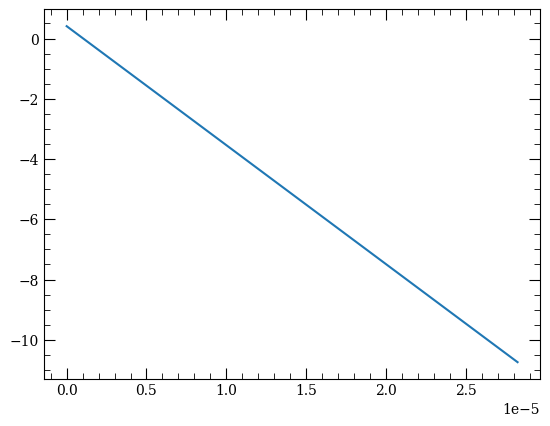

In [12]:

fig = plt.figure()
plot(timeEval, x[1]*1e6)
fig

In [12]:
function simulate2(u0, param, RHS)

    boundMin, boundMax = minimum(OurSystem.Environment.grid[1]), maximum(OurSystem.Environment.grid[1])
    conditionStop(y, t, integrator) = !any(boundMin + 1e-6 .< y[1:3]) || !any(y[1:3] .< boundMax - 1e-6)
    affect!(integrator) = terminate!(integrator)
    cb = DiscreteCallback(conditionStop, affect!)

    tspan = (0, 10e-6)
    prob = ODEProblem(RHS, u0, tspan, param)
    dt = 2e-9
    sol = solve(prob, RK4(), dt=dt, adaptive=false, callback = cb)#, callback=cb, abstol=1e-3, reltol=1e-3)
    return sol.t, hcat(sol.u...)
end


simulate2 (generic function with 1 method)

In [13]:
u0, param, RHS = InitializeProblem(OurSystem, 1, 1e-3, "Fspont_R", opt_args=0.0);

In [14]:
t, u = simulate2(u0, param, RHS)
x, y, z, vx, vy, vz = u[1, :],  u[2, :],  u[3, :],  u[4, :], u[5, :], u[6, :];

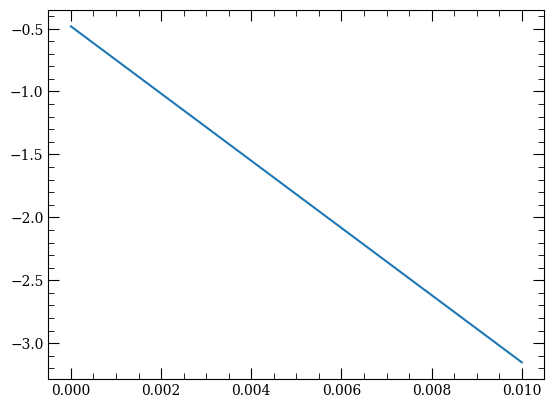

In [15]:


fig = plt.figure()
plot(t*1e3, x*1e6)

#xlim([0, 1e-3])

fig


In [27]:
OurSystem

System(atomInterface(PyObject <arc.alkali_atom_data.Cesium object at 0x13f86dc40>), Any[Tweezer_WF{Float64}(413304.00367474376, 292250.06368996104, GaussianBeam(BeamProperties{Vector{Float64}}([0.0, 0.0, 0.0], [0.0, 0.0, 1.0], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im], 1.0e10, 1.0e10), 0.02746002942263213, 2.8176546804511275e14), 2.206946951453701e-25, Main.CoolTrap.var"#ForceInterp#25"{Tweezer{Float64}, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}(Tweezer{Float64}(413304.00367474376, 292250.06368996104, GaussianBeam(BeamProperties{Vector{Float64}}([0.0, 0.0, 0.0], [0.0, 0.0, 1.0], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im], 1.0e10, 1.0e10), 0.02746002942263213, 2.8176546804511275e14), 3.351227410563453e14, 0.02746002942263213, 2.2069469514537

In [28]:
using Base.Threads

In [29]:
a, b, c = 

ErrorException: syntax: incomplete: premature end of input

In [30]:
vcat([1, 2, 3]..., [3, 4, 5]..., 0)

7-element Vector{Int64}:
 1
 2
 3
 3
 4
 5
 0

In [31]:
using Base.Threads

function run()
    u0, param, RHS = InitializeProblem(OurSystem, 1, 1e-6, "Fabs_spont_R", opt_args=0.0);
    @threads for i in 1:20
        t, u = simulate(u0, param, RHS)
    end
end
println(Threads.nthreads())
@btime run()

#x, y, z, vx, vy, vz = u[1, :],  u[2, :],  u[3, :],  u[4, :], u[5, :], u[6, :];

8


LoadError: LoadError: UndefVarError: @btime not defined
in expression starting at /Users/jluke/Desktop/Simulation/HighFieldImaging/SimulatorJulv2.ipynb:10

In [13]:
Int(length([1, 2, 3, 6, 7, 8])/2)

3

In [31]:
cumsum([1, 2, 3])

3-element Vector{Int64}:
 1
 3
 6

In [16]:
function checkIt(a)
    return a, 1
end
a = 1
b = checkIt(a)

(1, 1)

In [27]:
a = [[[1, 2, 3], 2, 3], [4, 5, 6]]
a[1][1]

3-element Vector{Int64}:
 1
 2
 3

In [11]:


fig = plt.figure()
plot(t*1e3, x*1e6)

#xlim([0, 1e-3])

fig


UndefVarError: UndefVarError: t not defined

In [217]:
usoi
norm([1, 2, 3]/sum()

UndefVarError: UndefVarError: usoi not defined

In [221]:
using Random
a = [1, 2, 3, 4, 5]
b = randn(length(a))
println(findfirst(a .> b))

1


In [222]:
push!(tupl3, 2)

UndefVarError: UndefVarError: tupl3 not defined

In [223]:
a = [1, 2, 3, 2]
b = rand(length(a))
inds = findall(a .> b)
argmax(a[inds])

3

In [224]:
import Pkg; Pkg.add("StatsBase")

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


# SPEED

In [226]:
MOT_Test = OurSystem.MOTConfig[1]

MOT_Beam{Float64}(2.2099411934454452e15, 3.0e6, [-7.37142281580863e6, 0.0, 0.0], 3.281495681821934e7, 3.281495681821934e7, 11.023700310506518, GaussianBeam(BeamProperties{Vector{Float64}}([0.0, 0.0, 0.0], [-1.0, 0.0, 0.0], ComplexF64[0.7071067811865475 + 0.0im, 0.0 - 0.7071067811865475im, 0.0 + 0.0im], 1.0e10, 1.0e10), 14.0, 2.2099411964454452e15), Main.CoolTrap.var"#2#8"{Float64}(0.3174977458942898), Environment_T(Any[[0.5369241691980856 0.5722739059351407 … 0.5722739059351407 0.5369241691980856; 0.5722739059351407 0.6104284527223567 … 0.6104284527223567 0.5722739059351407; … ; 0.5722739059351407 0.6104284527223567 … 0.6104284527223567 0.5722739059351407; 0.5369241691980856 0.5722739059351407 … 0.5722739059351407 0.5369241691980856;;; 0.5416457853041334 0.5773063813689993 … 0.5773063813689993 0.5416457853041334; 0.5773063813689993 0.6157964524871437 … 0.6157964524871437 0.5773063813689993; … ; 0.5773063813689993 0.6157964524871437 … 0.6157964524871437 0.5773063813689993; 0.54164578530

In [227]:
@code_warntype get_Fnet(MOT_Test, [0.0, 0, 0], [0.0, 0, 0])

MethodInstance for Main.CoolTrap.get_Fnet(::MOT_Beam{Float64}, ::Vector{Float64}, ::Vector{Float64})
  from get_Fnet(MBeam::MOT_Beam, pos, vel) in Main.CoolTrap at /Users/jluke/Desktop/Simulation/HighFieldImaging/TrajModules.jl:238
Arguments
  #self#::Core.Const(Main.CoolTrap.get_Fnet)


  MBeam::MOT_Beam{Float64}
  pos::Vector{Float64}
  vel::Vector{Float64}
Body::Any


1 ─ %1 = Core

.typeassert(MBeam, Main.CoolTrap.MOT_Beam)::MOT_Beam{Float64}
│  

 %2 = Main.CoolTrap.get_Fnet(%1, pos, vel, 0)::Any
└──      return %2

